In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [3]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'gmm_exp' in c['name'] 
        and c['config']['experiment']['latent_dim'] == 64
        and c['config']['experiment']['hidden_dim'] == 128
        and c['config']['dataset']['prior_mu'] == [0, 5]
        and hasattr(c['config']['encoder'], 'layers')
        and c['config']['encoder']['layers'] == 4 
]   
# cfgs = [cfgs[1]]


import hydra
# load + prep dataset
def prepare_dataset_and_mixer(cfg, set_size=None, n_sets=None, n_mixed_sets=None):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    if set_size is not None:
        cfg['dataset']['set_size'] = set_size
    if n_sets is not None:
        cfg['dataset']['n_sets'] = n_sets
    if n_mixed_sets is not None:
        cfg['mixer']['n_mixed_sets'] = n_mixed_sets
    dataset = hydra.utils.instantiate(cfg['dataset'])
    mixer = hydra.utils.instantiate(cfg['mixer'])
    return dataset, mixer


# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

enc, gen = load_model(cfgs[0]['config'], cfgs[0]['dir'], device)


In [4]:
cfgs

[{'name': 'gmm_exp_7887ebf20a7a0786cb8a59b21a79c236',
  'dir': '../outputs/gmm_exp_7887ebf20a7a0786cb8a59b21a79c236',
  'config': {'dataset': {'_target_': 'datasets.distribution_datasets.MultivariateNormalDistributionDataset', 'n_sets': 50000, 'set_size': '${experiment.set_size}', 'data_shape': [2], 'seed': '${seed}', 'prior_mu': [0, 5], 'prior_cov_df': 10, 'prior_cov_scale': 1}, 'encoder': {'_target_': 'encoder.encoders.DistributionEncoderResNet', 'in_dim': '${dataset.data_shape[0]}', 'latent_dim': '${experiment.latent_dim}', 'hidden_dim': '${experiment.hidden_dim}', 'set_size': '${experiment.set_size}', 'layers': 4, 'fc_layers': 2}, 'model': {'_target_': 'layers.MLP', 'in_dims': [2, 64, 1], 'hidden_dim': 128, 'out_dim': 2, 'layers': 4}, 'generator': {'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'betas': [0.0001, 0.02], 'n_T': 400, 'drop_prob': 0.1, 'noise_shape': '${dataset.data_shape}'}, 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': '${experiment.

In [5]:
from torch.utils.data import DataLoader

ds, mx = prepare_dataset_and_mixer(cfgs[0]['config'], set_size=1_000_000, n_sets=10000, n_mixed_sets=16)
dl = DataLoader(ds, batch_size=16, shuffle=True, collate_fn=mx.collate_fn)




In [8]:
import numpy as np
import torch
import gc


from ot.gmm import gmm_ot_loss

latent_dists = []
ot_dists = []

gc.collect()
torch.cuda.empty_cache()

for i, (batch_s, batch_t) in enumerate(zip(iter(dl), iter(dl))):
    print(f'{i}/{len(dl)}')
    samples_s = batch_s['samples'].to(device)
    means_s = batch_s['mean'].to(device)
    covs_s = batch_s['cov'].to(device)
    weights_s = batch_s['weights'].to(device)
    samples_t = batch_t['samples'].to(device)
    means_t = batch_t['mean'].to(device)
    covs_t = batch_t['cov'].to(device)
    weights_t = batch_t['weights'].to(device)

    with torch.no_grad():
        enc_s = enc(samples_s).detach().cpu().numpy()
        enc_t = enc(samples_t).detach().cpu().numpy()


    latent_dists.append(np.linalg.norm(enc_s - enc_t, axis=1))
    # this is simply impossible to vectorize, vmap fails because they compute the sinkhorn with numpy primitives
    ot_dists += [
        gmm_ot_loss(means_si, means_ti, covs_si, covs_ti, weights_si, weights_ti).detach().cpu().numpy() 
        for means_si, means_ti, covs_si, covs_ti, weights_si, weights_ti in zip(means_s, means_t, covs_s, covs_t, weights_s, weights_t)
    ]

    # clear cuda cache
    gc.collect()
    torch.cuda.empty_cache()


0/625
1/625
2/625
3/625
4/625
5/625
6/625
7/625
8/625
9/625
10/625
11/625
12/625
13/625
14/625
15/625
16/625
17/625
18/625
19/625
20/625
21/625
22/625
23/625
24/625
25/625
26/625
27/625
28/625
29/625
30/625
31/625
32/625
33/625
34/625
35/625
36/625
37/625
38/625
39/625
40/625
41/625
42/625
43/625
44/625
45/625
46/625
47/625
48/625
49/625
50/625
51/625
52/625
53/625
54/625
55/625
56/625
57/625
58/625
59/625
60/625
61/625
62/625
63/625
64/625
65/625
66/625
67/625
68/625
69/625
70/625
71/625
72/625
73/625
74/625
75/625
76/625
77/625
78/625
79/625
80/625
81/625
82/625
83/625
84/625
85/625
86/625
87/625
88/625
89/625
90/625
91/625
92/625
93/625
94/625
95/625
96/625
97/625
98/625
99/625
100/625
101/625
102/625
103/625
104/625
105/625
106/625
107/625
108/625
109/625
110/625
111/625
112/625
113/625
114/625
115/625
116/625
117/625
118/625
119/625
120/625
121/625
122/625
123/625
124/625
125/625
126/625
127/625
128/625
129/625
130/625
131/625
132/625
133/625
134/625
135/625
136/625
137/625
138/62

In [9]:
latent_dists = np.concatenate(latent_dists)
ot_dists = np.sqrt(np.array(ot_dists))

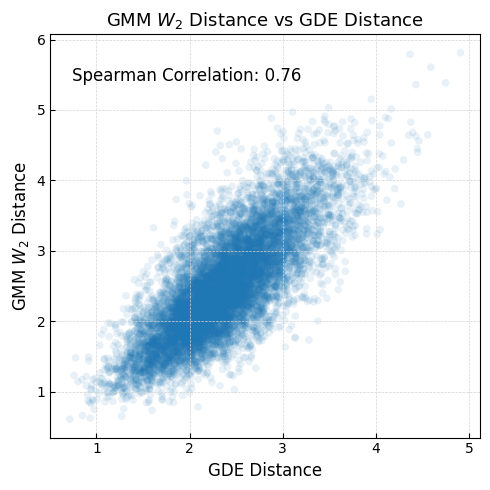

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Set up figure and axis
fig, ax = plt.subplots(figsize=(5, 5))

# Plot scatter
ax.scatter(latent_dists, ot_dists.flatten(), alpha=0.1, s=30, edgecolor='none')

# Labels and title
ax.set_xlabel('GDE Distance', fontsize=12)
ax.set_ylabel('GMM $W_2$ Distance', fontsize=12)
ax.set_title('GMM $W_2$ Distance vs GDE Distance', fontsize=13)

# Grid: light gray, dashed, thin — to match other plots
ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5)

# Ticks inside, no top/right ticks
ax.tick_params(direction='in', top=False, right=False)

# Tighten layout
plt.tight_layout()

# Annotate correlation
rho, _ = spearmanr(latent_dists, ot_dists.flatten())
ax.text(0.05, 0.92, f'Spearman Correlation: {rho:.2f}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Save
plt.savefig('../figs/gmm_dists.png', dpi=300)
plt.show()

# save actual data to numerical results
np.savez(
    '../numerical_results/gmm_dists.npz', 
    gde_dists=latent_dists, 
    ot_dists=ot_dists
)
